In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab_Notebooks/DLSchool_mipt_2sem")

In [ ]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 2.1MB 12.9MB/s 
     |████████████████████████████████| 194kB 46.9MB/s 
     |████████████████████████████████| 3.3MB 49.6MB/s 
     |████████████████████████████████| 870kB 59.1MB/s 
     |████████████████████████████████| 245kB 62.3MB/s 
     |████████████████████████████████| 112kB 53.1MB/s 


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [ ]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/aa34462255cd487d04be8387a2d572588f6ceee23f784f37365aa714afeb8fe6. Subsequent calls will reuse this data.


Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

0

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
# Если надо, попрактикуйся работать с токенайзером здесь
emotion_dataset["train"]["label"][15]

1

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(
            text, 
            max_length=self.max_length, # максимальная длина текста
            padding="max_length", # надо ли добавлять паддинг в конце?
            return_tensors="pt", # возвращает pytorch тензоры
        )
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output["input_ids"].flatten(), 
            "mask": tokenizer_output["attention_mask"].flatten(),
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [ ]:
train_dataset = TweetDataset("train")
valid_dataset = TweetDataset("validation") # validation
test_dataset = TweetDataset("test")

In [ ]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=True
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
tokens = train_dataset[0]["input_ids"].unsqueeze(0).to(device) # Получи токены из датасета
mask = train_dataset[0]["mask"].unsqueeze(0).to(device) # Получи маску из датасета

model_0(input_ids=tokens, attention_mask=mask).keys() # Посмотри на аутпут

odict_keys(['logits', 'past_key_values', 'attentions'])

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [ ]:
%%time
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
train_losses = []
valid_losses = []
valid_accs = []

for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        tokens = batch["input_ids"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)

        logits = model_0(input_ids=tokens, attention_mask=mask).logits
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.data.item()

    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            tokens = batch["input_ids"].to(device)
            mask = batch["mask"].to(device)
            target = batch["target"].to(device)

            logits = model_0(input_ids=tokens, attention_mask=mask).logits
            loss = criterion(logits, target)
            pred_labels = logits.argmax(dim=-1)
            acc = (pred_labels == target).sum().item() / len(target)

            valid_loss += loss.data.item()
            valid_acc += acc
    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    valid_acc /= len(valid_loader)
    print(f"Epoch: {e+1}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Valid Acc: {valid_acc}")
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens = batch["input_ids"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)

        logits = model_0(input_ids=tokens, attention_mask=mask).logits
        loss = criterion(logits, target)
        pred_labels = logits.argmax(dim=-1)
        acc = (pred_labels == target).sum().item() / len(target)

        test_acc += acc
test_acc /= len(test_loader)
# print(f"\nTest Acc: {test_acc}")


Epoch: 1, Train Loss: 1.5623361496925354, Valid Loss: 1.4391228184103966, Valid Acc: 0.45751953125



Epoch: 2, Train Loss: 1.2928354532718658, Valid Loss: 1.0431875716894865, Valid Acc: 0.60693359375



Epoch: 3, Train Loss: 0.9193667244911193, Valid Loss: 0.8101586159318686, Valid Acc: 0.69091796875



Epoch: 4, Train Loss: 0.6615941492319107, Valid Loss: 0.6486177686601877, Valid Acc: 0.76806640625



Epoch: 5, Train Loss: 0.48614943915605546, Valid Loss: 0.5750012593343854, Valid Acc: 0.794921875



Epoch: 6, Train Loss: 0.3687283532321453, Valid Loss: 0.49527658615261316, Valid Acc: 0.83251953125



Epoch: 7, Train Loss: 0.27994650933146475, Valid Loss: 0.4926385092549026, Valid Acc: 0.8486328125



Epoch: 8, Train Loss: 0.21926446563005447, Valid Loss: 0.4694462255574763, Valid Acc: 0.8515625



Epoch: 9, Train Loss: 0.18404586404561996, Valid Loss: 0.45851943269371986, Valid Acc: 0.86279296875



Epoch: 10, Train Loss: 0.15665364460647105, Valid Loss: 0.4195230782497674, Valid Acc: 0.87158203125
CPU times: user 56min 38s, sys: 4min 47s, total: 1h 1min 26s
Wall time: 1h 1min 10s


In [ ]:
print(f"Test Acc: {test_acc}")

Test Acc: 0.85107421875


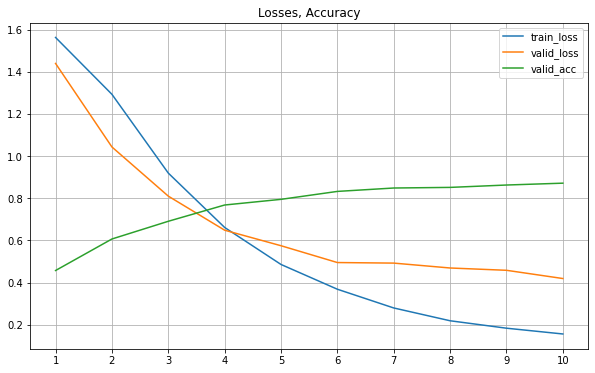

In [ ]:
plt.figure(figsize=(10, 6))
epoch = range(1, 11)
plt.plot(epoch, train_losses, label="train_loss")
plt.plot(epoch, valid_losses, label="valid_loss")
plt.plot(epoch, valid_accs, label="valid_acc")
plt.grid()
plt.xticks(epoch)
plt.title("Losses, Accuracy")
plt.legend();

In [ ]:
# torch.save(model_0.state_dict(), "model_0.pt")
# model_0.load_state_dict(torch.load("model_0.pt"))
# model_0.eval()

После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [ ]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn), seq

In [ ]:
def show_attention(seq, attentions, ax=None):
    # Set up figure with colorbar
    if ax is None:
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(111)
        cax = ax.matshow(attentions)
        fig.colorbar(cax)
    else:
        ax = ax
        cax = ax.matshow(attentions)

    # Set up axes

    if seq is None:
        seq = [''] * attentions.shape[-1]
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

In [ ]:
text = emotion_dataset["train"]["text"][1] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

In [ ]:
attns, seq = get_attention_matrixes(model_0, tokenizer, text)
show_attention(seq, attns[-1][0])

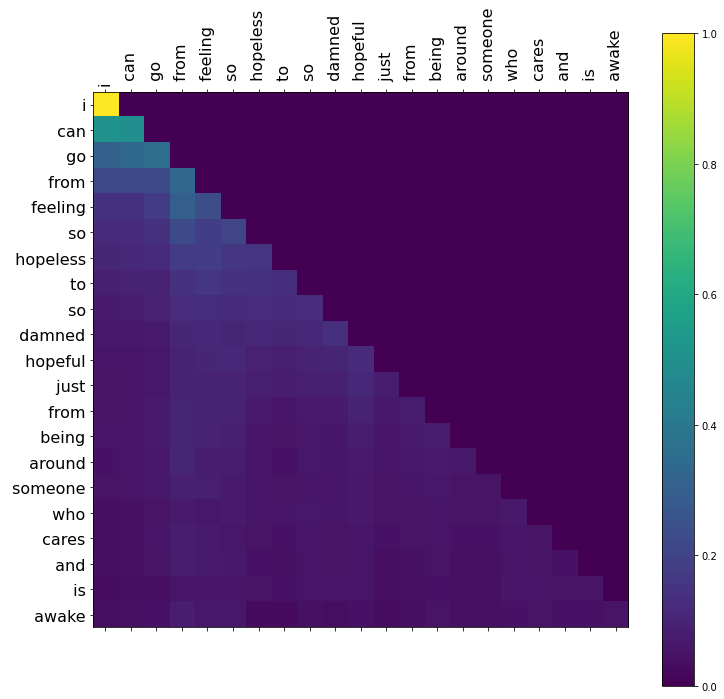

In [ ]:
show_attention(seq, attns[-2][0])

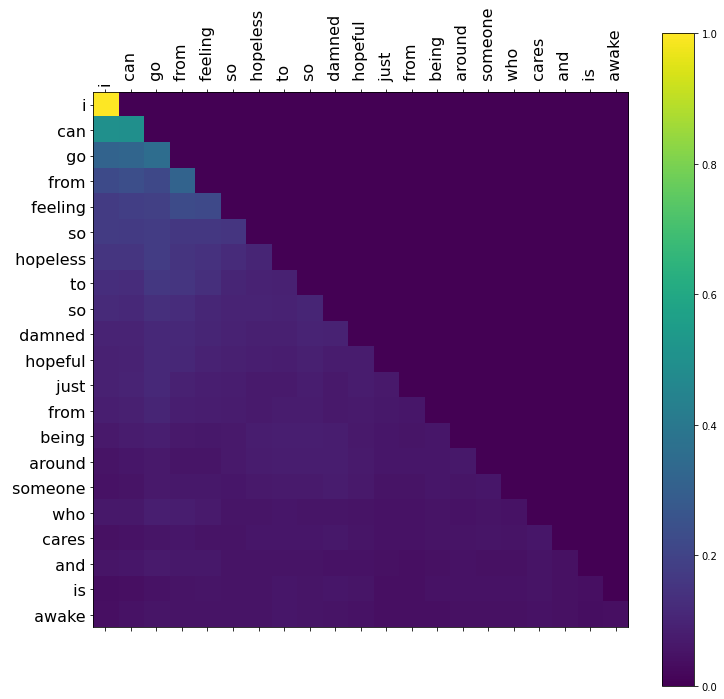

In [ ]:
show_attention(seq, attns[-1][11])

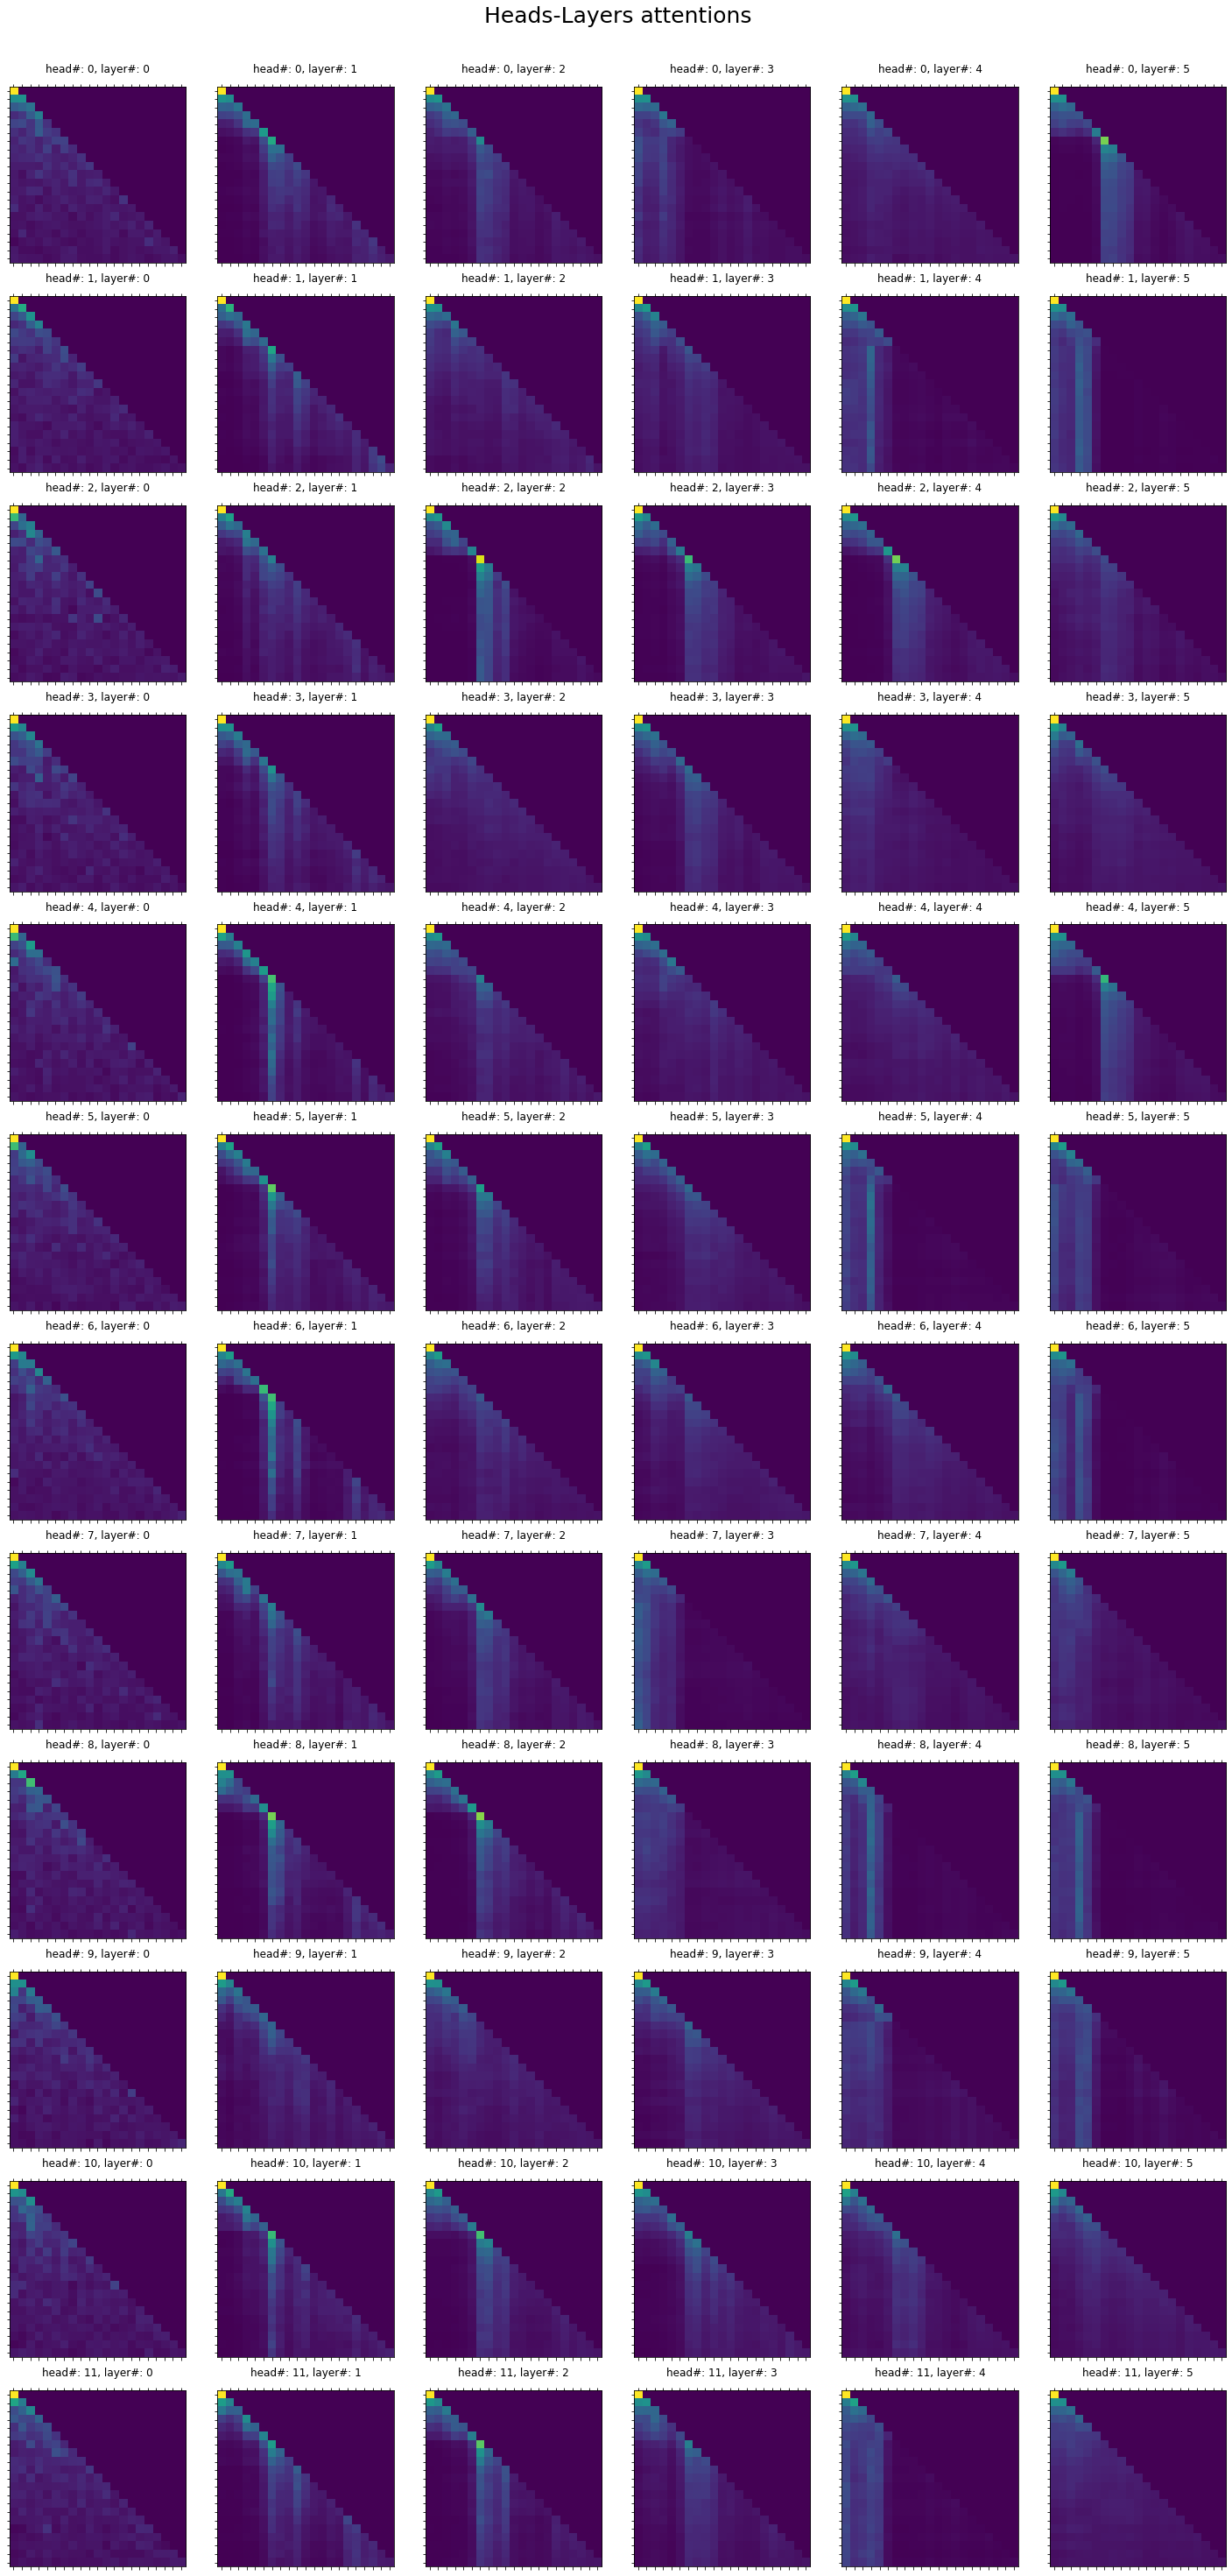

In [ ]:
heads_num = attns.shape[1]
layers_num = attns.shape[0]

fig, axes = plt.subplots(heads_num, layers_num, figsize=(20, 40))

for head_n in range(heads_num):
    for layer_n in range(layers_num):
        ax = axes[head_n, layer_n]
        show_attention(None, attns[layer_n][head_n], ax)
        ax.set_title(f"head#: {head_n}, layer#: {layer_n}")
fig.suptitle('Heads-Layers attentions', y=1.02, fontsize=25)
fig.tight_layout()

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [ ]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [ ]:
%%time
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
train_losses = []
valid_losses = []
valid_accs = []

for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        tokens = batch["input_ids"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)

        logits = model_1(input_ids=tokens, attention_mask=mask).logits
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.data.item()

    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            tokens = batch["input_ids"].to(device)
            mask = batch["mask"].to(device)
            target = batch["target"].to(device)

            logits = model_1(input_ids=tokens, attention_mask=mask).logits
            loss = criterion(logits, target)
            pred_labels = logits.argmax(dim=-1)
            acc = (pred_labels == target).sum().item() / len(target)

            valid_loss += loss.data.item()
            valid_acc += acc
    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    valid_acc /= len(valid_loader)
    print(f"Epoch: {e+1}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Valid Acc: {valid_acc}")
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens = batch["input_ids"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)

        logits = model_1(input_ids=tokens, attention_mask=mask).logits
        loss = criterion(logits, target)
        pred_labels = logits.argmax(dim=-1)
        acc = (pred_labels == target).sum().item() / len(target)

        test_acc += acc
test_acc /= len(test_loader)
# print(f"\nTest Acc: {test_acc}")


Epoch: 1, Train Loss: 1.4069947168827057, Valid Loss: 0.8116472195833921, Valid Acc: 0.7216796875



Epoch: 2, Train Loss: 0.5488943548202515, Valid Loss: 0.2886819416889921, Valid Acc: 0.90283203125



Epoch: 3, Train Loss: 0.30429183438420293, Valid Loss: 0.20273804728640243, Valid Acc: 0.92578125



Epoch: 4, Train Loss: 0.22215681228041648, Valid Loss: 0.17761882045306265, Valid Acc: 0.92919921875



Epoch: 5, Train Loss: 0.18433360266685486, Valid Loss: 0.1586676028673537, Valid Acc: 0.93212890625



Epoch: 6, Train Loss: 0.16021441484987736, Valid Loss: 0.1574515247484669, Valid Acc: 0.9345703125



Epoch: 7, Train Loss: 0.14466202469170095, Valid Loss: 0.15245181494537974, Valid Acc: 0.93212890625



Epoch: 8, Train Loss: 0.12893277956545354, Valid Loss: 0.14200094726402313, Valid Acc: 0.9306640625



Epoch: 9, Train Loss: 0.12168487633019685, Valid Loss: 0.1594595795031637, Valid Acc: 0.93798828125



Epoch: 10, Train Loss: 0.11465050667524337, Valid Loss: 0.14183745707850903, Valid Acc: 0.9384765625
CPU times: user 58min 39s, sys: 4min 52s, total: 1h 3min 31s
Wall time: 1h 3min 14s


In [ ]:
print(f"Test Acc: {test_acc}")

Test Acc: 0.9267578125


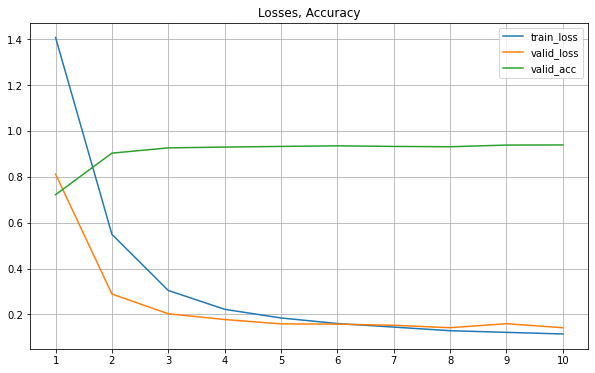

In [ ]:
plt.figure(figsize=(10, 6))
epoch = range(1, 11)
plt.plot(epoch, train_losses, label="train_loss")
plt.plot(epoch, valid_losses, label="valid_loss")
plt.plot(epoch, valid_accs, label="valid_acc")
plt.grid()
plt.xticks(epoch)
plt.title("Losses, Accuracy")
plt.legend();

In [ ]:
# torch.save(model_1.state_dict(), "model_1.pt")
# model_1.load_state_dict(torch.load("model_1.pt"))
# model_1.eval()

Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [ ]:
text = emotion_dataset["train"]["text"][1] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

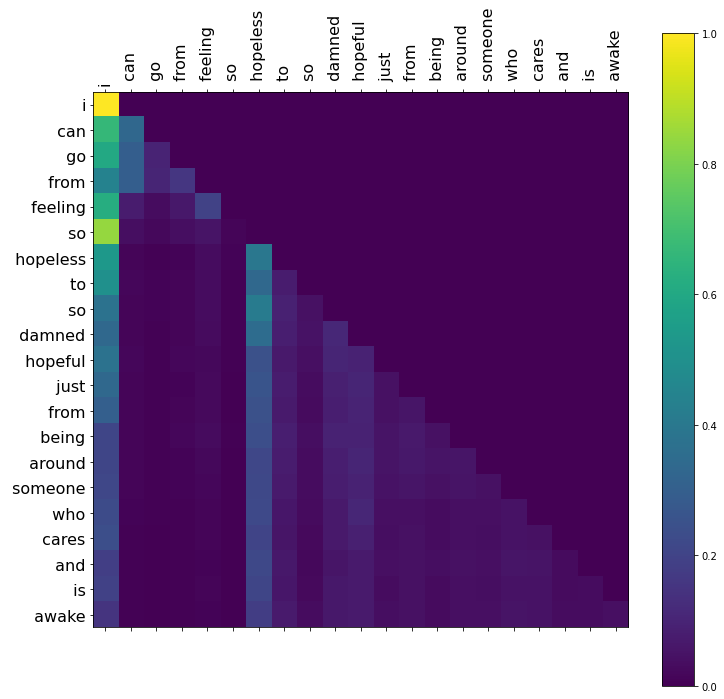

In [ ]:
attns, seq = get_attention_matrixes(model_1, tokenizer, text)
show_attention(seq, attns[-1][0])

In [ ]:
attns.shape

(6, 12, 21, 21)

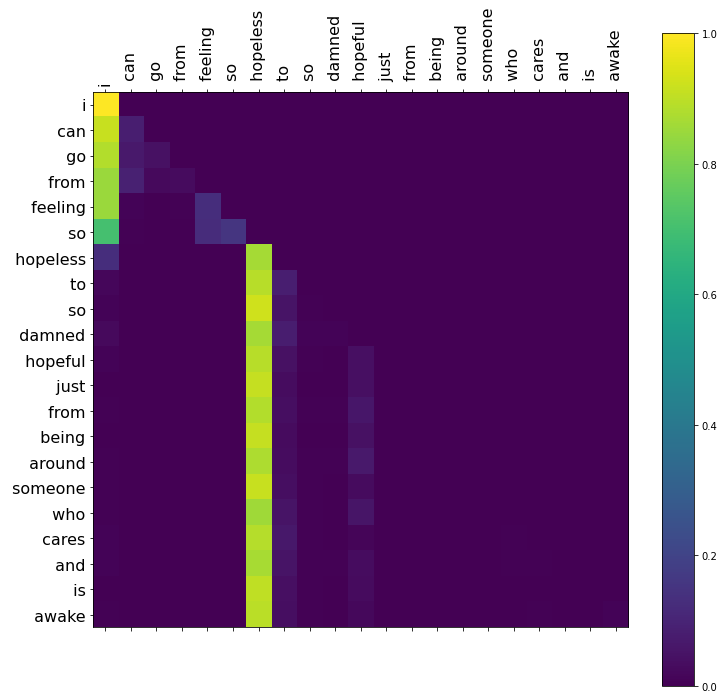

In [ ]:
show_attention(seq, attns[-2][0])

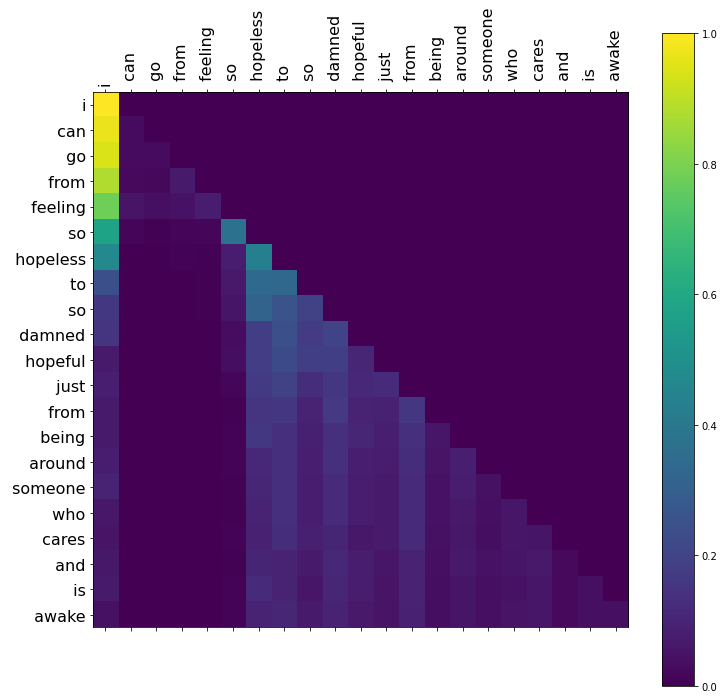

In [ ]:
show_attention(seq, attns[-1][1])

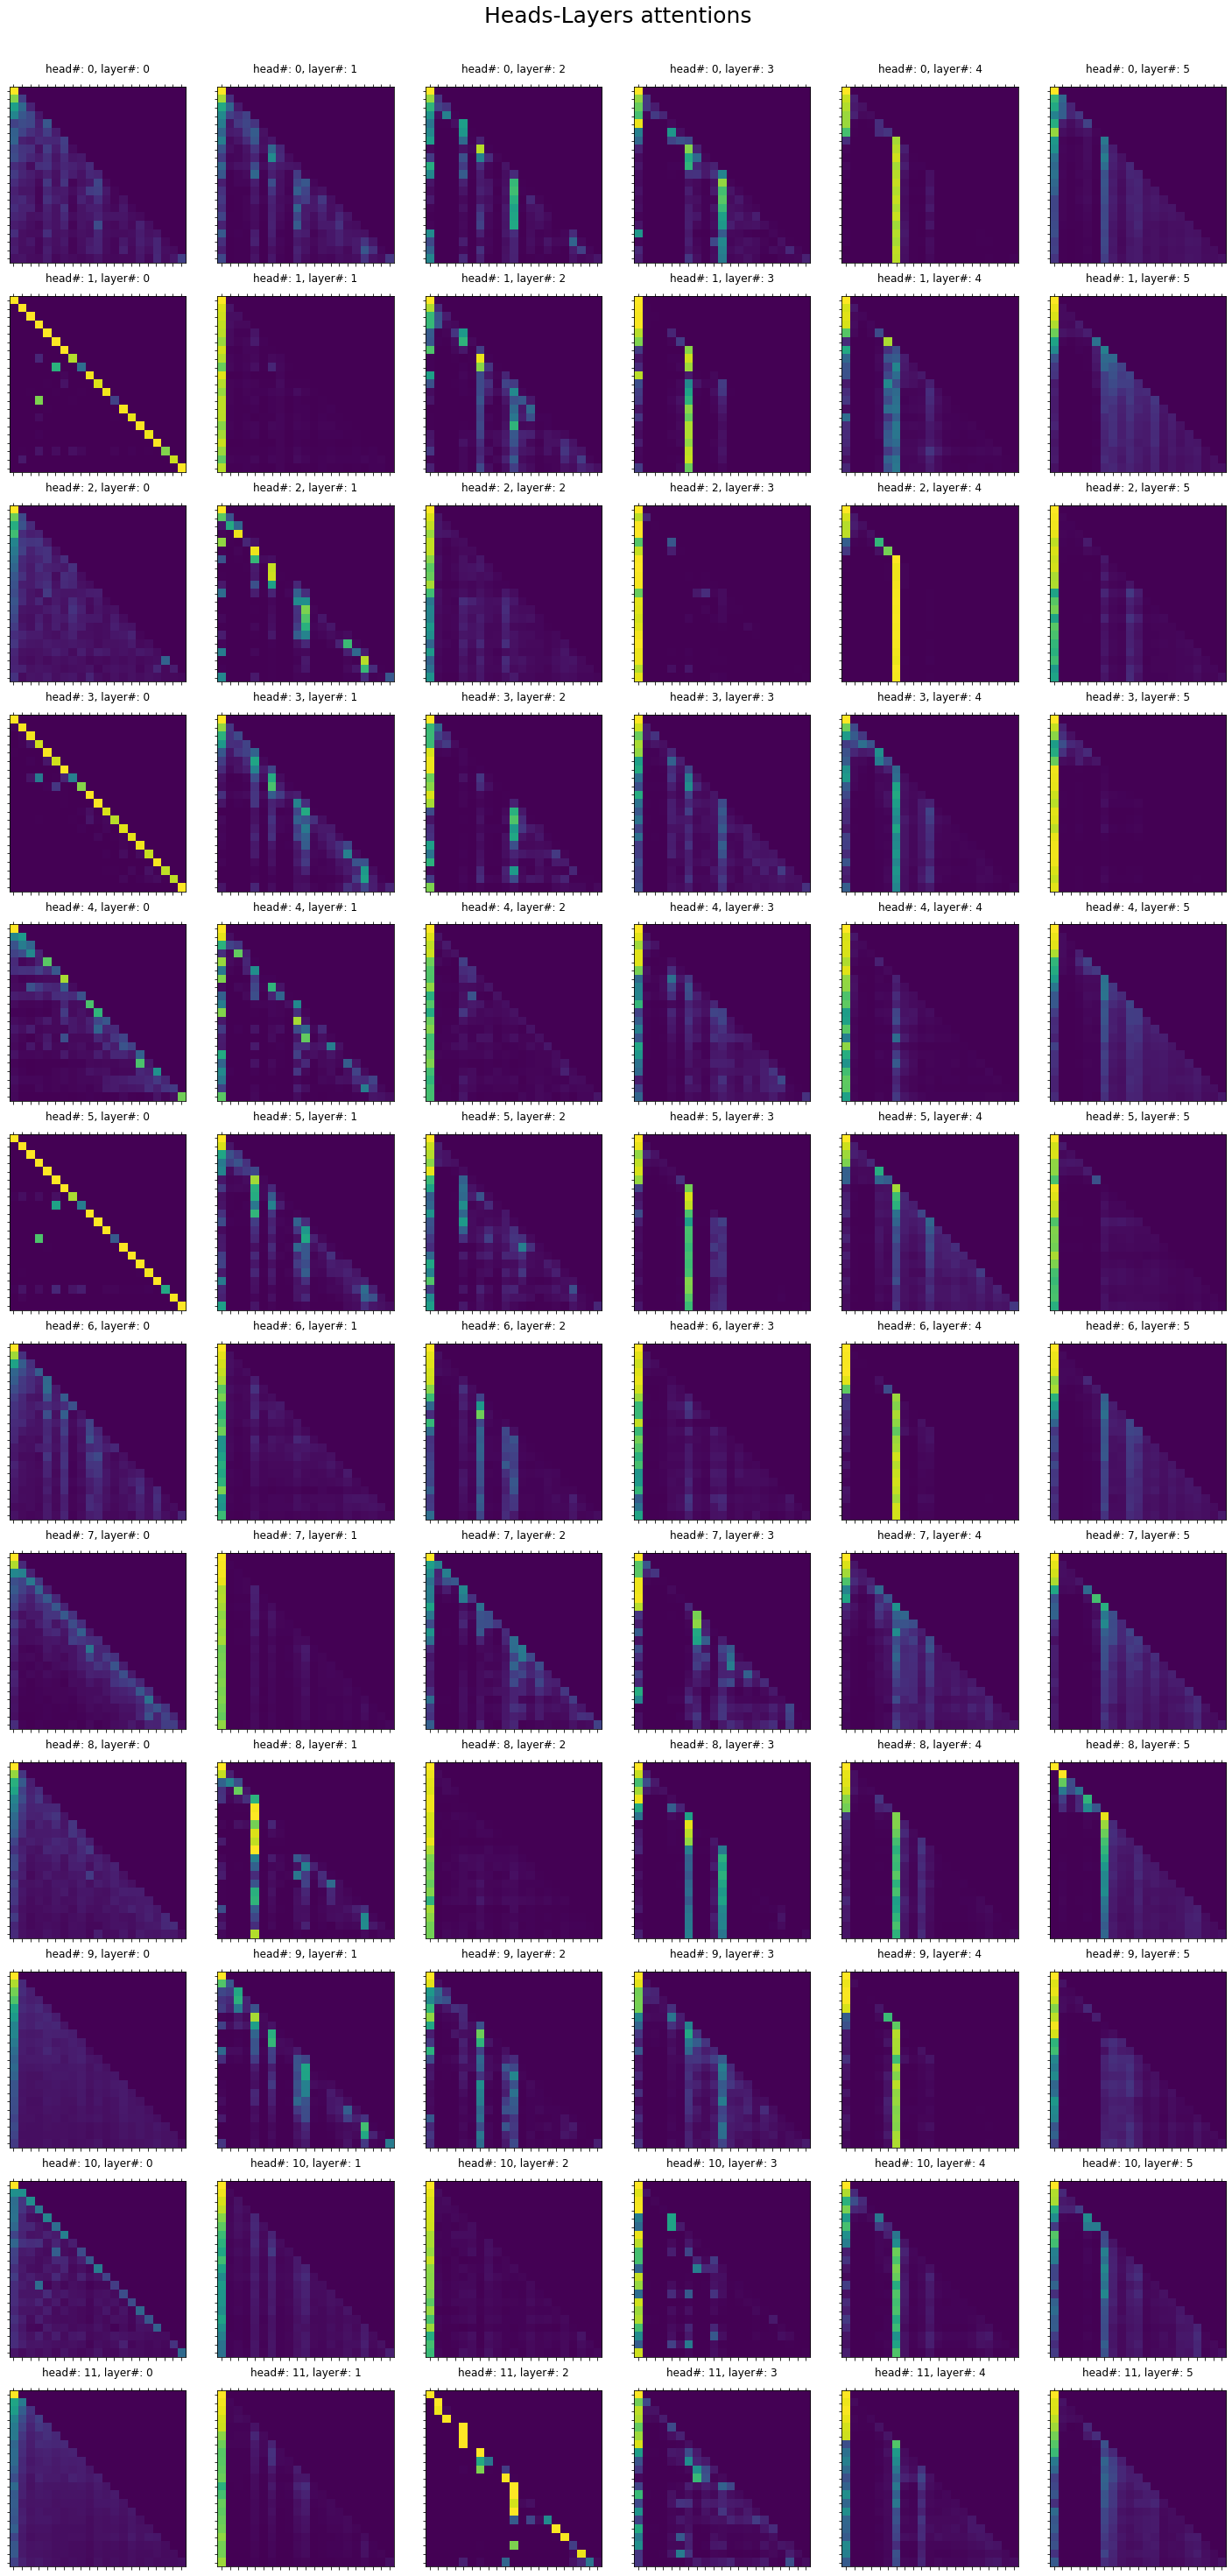

In [ ]:
heads_num = attns.shape[1]
layers_num = attns.shape[0]

fig, axes = plt.subplots(heads_num, layers_num, figsize=(20, 40))

for head_n in range(heads_num):
    for layer_n in range(layers_num):
        ax = axes[head_n, layer_n]
        show_attention(None, attns[layer_n][head_n], ax)
        ax.set_title(f"head#: {head_n}, layer#: {layer_n}")
fig.suptitle('Heads-Layers attentions', y=1.02, fontsize=25)
fig.tight_layout()

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?   
### ВЫВОДЫ:
- Второй подход - с Fine-tuning -  оказался значительно лучше. Модель обучилась лучше и гораздо быстрее. Уже после 3й эпохи на валидации аккураси было более 92%, в то время как при обучении с нуля на 3 эпохе было только 69%, а на 10й эпохе - 86%.
- В первом варианте, как мне показалось, модель больше смотрит на глаголы. Но это не ярко выражено, внимание размыто.     
Но вот **во втором** варианте, с fine-tuning, интересно, почти вся модель смотрит в основном на **первое** слово - подлежащее, местоимение I. И это ярко выражено.
- Анализируя карты внимания для обеих моделей, можно сказать:    
    - **В первом варианте** (с нуля) внимание распределено более-менее однородно и похожим образом на разных слоях-головах.    
    - **Во втором же варианте** (**fine-tuning**)  внимание более акцентировано на каких-то отдельных словах, причем в разных слоях-головах - на разных (см. карты внимания). 